# Задача

1. Разбить данные на обучающую и валидационную выборку

2. Построить классификатор пар вопросов на дубликаты/не дубликаты.

3. Для вопроса с qid=1 найти 100 самых похожих вопросов  среди вопросов с q_id=1-121424

# Решение

1. В данных обнаружено большое количество дубликатов вопросов, которые можно найти только по текстовому сравнению. Около 20к вопросов из 180к вcтречаются более 5 раз. Это достаточно критично на этапе построения валидации, так как цель работы получить модель, обобщающая способность которой должна рапространятся на тексты различного характера, то попадание одних и тех же вопросов и в трейн и в валидацию не позволит правильным образом сделать такую оценку.

2. В качестве классификатора будут использованы два принципиально разных подхода:
    * Классификатор вопросов на дубликаты/не дубликаты с помощью BERT. Благодаря тому, что на этапе претрейна языковой модели одной из задач была классификация пар предложений на предмет, является ли одно из них продолжением другого, BERT в своей архитектуре содержит возможность матчинга пар дубликат/не дубликат. Однако у такого подхода есть один большой минус - нельзя заранее предрасчитать эмбединги предложений, чтобы потом быстро находить дубликаты при помощи, например, cos similarity. Однако, его можно использовать как ранжирующую систему, после поиска ближайших какой-либо первоначальной моделью. 
    * Классифиикатор вопросов на основи сиамской сети с ELMO энкодингом. В таком подходе оба вопроса кандидата пропускаются через один и тот же претрейн блок ELMO, после чего по l1 расстоянию полученных эмбедингов 1 линеный слой решает, являются ли эти вопросы дубликатами. После обучения такой сети у нас получается fine-tune энкодер ELMO, с помощью которого можно заранее посчитать все эмбединги вопросов, и на этапе инференса пропускать в режиме большого батча пары таких вопросов через голову сети, либо же на этапе обучения использовать лоссы из metric learning, и после этого уже искать через, например, faiss.
    
    Для использования претрейн ELMO и BERT на английском языке используется моя кастомная обертка tf-hub моделей для [кераса](https://github.com/epoch8/keras_elmo_bert). Можно было использовать возможности tf-2.0, но он все еще в бете, там есть баги.
    
3. После обучения моделей, будет составлен датасет из вида вопрос с qid1 | все сотальные вопросы, по которым нужно провести поиск. Такой датасет пропущен через обученные модельки (ELMO, BERT). Топ 100 предсказаний по вероятности будут сохранены в соотвестующие директории в result 

In [1]:
#!nvidia-smi

In [2]:
import sys
sys.path.append('keras_elmo_bert/')

import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [39]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import itertools
import string
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import re

from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.layers import Layer
from keras.utils import Sequence
from keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, Flatten, GlobalMaxPool1D, LSTM, Dot, Lambda
from keras.layers import Input, MaxPooling1D, GlobalAveragePooling1D, multiply, concatenate, Reshape
from keras.layers import Bidirectional
from keras.optimizers import Adam
import keras.initializers as initializers
import keras.regularizers as regularizers
import keras.constraints as constraints


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle
import pickle

sess = tf.Session()

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
max_seq_length = 64
bert_path = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"
elmo_path = "https://tfhub.dev/google/elmo/2"

# Load data and small EDA

In [6]:
df = pd.read_csv('data/test_questions.csv')

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


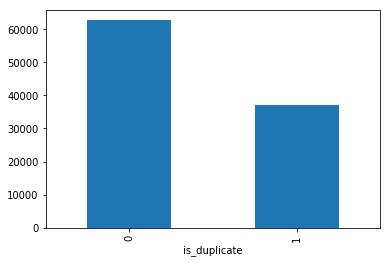

In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()

Total number of question pairs for training: 99996
Duplicate pairs: 37.26%
Total number of questions in the training data: 198429
Number of questions that appear multiple times: 1318



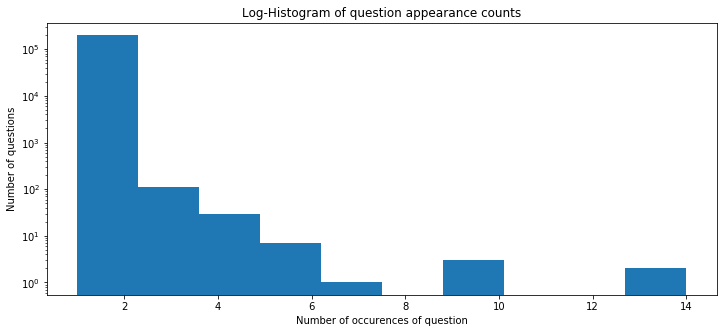

In [9]:
print('Total number of question pairs for training: {}'.format(len(df)))
print('Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=10)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [10]:
pd.set_option('max_colwidth', 200)
df.query('qid1 == 1 or qid1 == 1')

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0


In [11]:
all_ques_df = pd.concat([df[['qid1','question1']].rename(columns={"qid1": "qid", "question1": "questions"}), 
                         df[['qid2','question2']].rename(columns={"qid2": "qid", "question2": "questions"})],
                        axis =0, ignore_index=True)
all_ques_df.head()

,qid,questions
0,1,What is the step by step guide to invest in share market in india?
1,3,What is the story of Kohinoor (Koh-i-Noor) Diamond?
2,5,How can I increase the speed of my internet connection while using a VPN?
3,7,Why am I mentally very lonely? How can I solve it?
4,9,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?"


In [12]:
all_ques_df = all_ques_df.drop_duplicates(subset = ['qid'])

In [13]:
all_ques_df.shape

(198429, 2)

In [14]:
all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

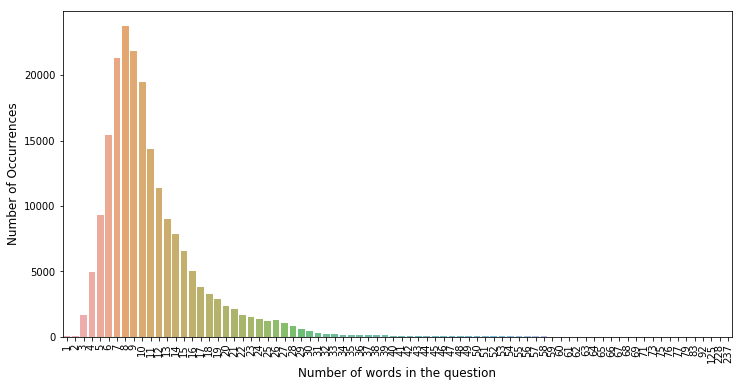

In [15]:
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## Let's look for duplicates in the text

In [16]:
dup_df = all_ques_df[all_ques_df.duplicated(subset = ['questions'], keep =False)].sort_values('questions')

In [17]:
dup_df.head(10)

,qid,questions,num_of_words
197203,192938,"""How do I get rid of acne and acne…?",9
6300,12590,"""How do I get rid of acne and acne…?",9
38558,76817,"""How do I get rid of acne and acne…?",9
74214,147478,"""How to make money?""",4
71049,141209,"""How to make money?""",4
26496,52838,"""How to move pre installed apps to SD card?""",9
9501,18974,"""How to move pre installed apps to SD card?""",9
25420,50699,"""How to move pre installed apps to SD card?""",9
17844,35609,"""What has passed is past"" vs ""What passed is past"", which one is correct?",14
67333,133866,"""What has passed is past"" vs ""What passed is past"", which one is correct?",14


Очень много дубликатов не по айди а по тексту. Обьединим все дубликаты в один айди. Это нескажется на процессе обучения, но необходимо для настрйоки корректной валидации. (Одни и те же вопросы не должны оставаться и в трейне и в тесте)

In [18]:
all_ques_df['new_qid'] = all_ques_df.groupby('questions').qid.transform(lambda x: x.min())

In [19]:
dup_df = all_ques_df[all_ques_df.duplicated(subset = ['questions'], keep =False)].sort_values('questions')

In [20]:
dup_df.head()

,qid,questions,num_of_words,new_qid
197203,192938,"""How do I get rid of acne and acne…?",9,12590
6300,12590,"""How do I get rid of acne and acne…?",9,12590
38558,76817,"""How do I get rid of acne and acne…?",9,12590
74214,147478,"""How to make money?""",4,141209
71049,141209,"""How to make money?""",4,141209


In [21]:
map_dict = dict(zip(*[all_ques_df['qid'].values, all_ques_df['new_qid'].values]))

In [22]:
dup_df['new_qid'].value_counts().head(5)

2568     33
4066     29
32213    25
12892    21
11455    20
Name: new_qid, dtype: int64

Посмотрим на самый часто втречаемый вопрос

In [23]:
df[['qid1_new', 'qid2_new']] = df[['qid1', 'qid2']].applymap(lambda x: map_dict.get(x, x))

In [24]:
df.query("qid1_new == 11455 or qid2_new == 11455")

,id,qid1,qid2,question1,question2,is_duplicate,qid1_new,qid2_new
5731,5731,11454,11455,How can I lose 10 Kilos?,What are the best was to lose weight?,1,11454,11455
6542,6542,13071,13072,What are the best way of loose the weight?,What are the best was to lose weight?,1,2722,11455
8969,8969,17914,17915,"What are the best ways to lose weight, especially around your core?",What are the best was to lose weight?,1,17914,11455
12197,12197,24352,24353,How can I lose weight loss?,What are the best was to lose weight?,1,19742,11455
16643,16643,33216,33217,What are the best was to lose weight?,How do I lose 20-30 kg?,1,11455,33217
17152,17152,34231,34232,What are the best was to lose weight?,How can I efficiently lose weight?,1,11455,4533
19680,19680,39271,39272,How do I lose 30 pounds?,What are the best was to lose weight?,1,39271,11455
20398,20398,40698,40699,How do i lose weight?,What are the best was to lose weight?,1,3613,11455
23234,23234,46355,46356,What are some good ways to lose weight?,What are the best was to lose weight?,1,46355,11455
24021,24021,47922,47923,What is the best way to reduce body weight?,What are the best was to lose weight?,1,44059,11455


Total number of question pairs for training: 99996
Duplicate pairs: 37.26%
Total number of questions in the training data: 164694
Number of questions that appear multiple times: 20277



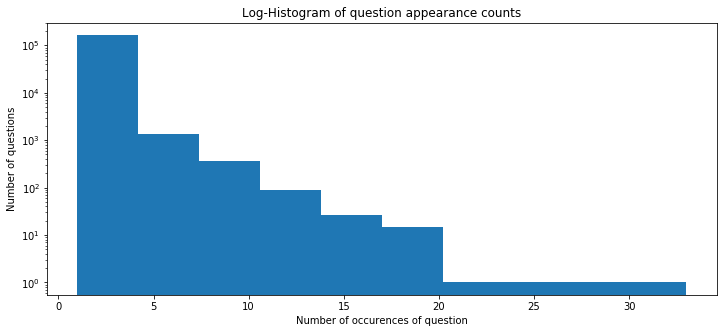

In [25]:
print('Total number of question pairs for training: {}'.format(len(df)))
print('Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df['qid1_new'].tolist() + df['qid2_new'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=10)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()